# HW02 Steve Yang

For this homework, I'm still using mushroom dataset, and using the best ten features that selected from HW01. For algorithms, I'm going to use <span style="color:blue">"GLM"</span>, <span style="color:blue">"SVM"</span> and <span style="color:blue">"naiveBayes"</span>

Beside implement CrossValidation,LOOCV,Bagging,randomForest,gbm,xgbm and stacking to my dataset, I also spent a lot of time on parallelize my implementation and try to implement reusable framework so that I do not custom scripts for each case. Basically, I write some common functions as helper functions, and I also implement my selected algorithms(glm, svm and naiveBayes) in each algorithm helper functions, so what I need to do is just use algoriothm name as input argument, and it will run the target algorithm. That's only one part of it, I will explain more details in <span style="color:blue">Helper Function</span> part.

## Helper Functions

### Introduction

I wrote total 7 helper functions. I also parallelize them, and I print the runtime for each of them. 

<span style="color:red">dataPreprocess(dataset,ratioOfTrain) </span> :This helper function can generate training set and test set. <span style="color:blue">dataset</span> argument is select the specific dataset (data direction). <span style="color:blue">ratioOfTrain</span> is the argument to set what ratio of data is training set. For example: dataPreprocess("/mushroom.csv",0.7) means we are using mushroom.csv as dataset and we take 70% of it as training data.

<span style="color:red">crossValidation(test) </span> :This helper function can run crossValidation with <span style="color:blue">test</span> algorithm. ("glm"/"svm"/"naiveBayes")

<span style="color:red">LOOCV(test) </span> :This helper function can run LOOCV with <span style="color:blue">test</span> algorithm. ("glm"/"svm"/"naiveBayes")

<span style="color:red">bagging(test) </span> :This helper function can run bagging with <span style="color:blue">test</span> algorithm. ("glm"/"svm"/"naiveBayes")

<span style="color:red">mrandomForest(ntree) </span> :This helper function can run mrandomForest with <span style="color:blue">ntree</span>.

<span style="color:red">mushroom_gbm(ntree) </span> :This helper function can run gbm with <span style="color:blue">ntree</span> .

<span style="color:red">mushroom_xgbm() </span> :This helper function can run xgbm.

The reason why I wrote in this way is because I can combine the last six function with <span style="color:red">dataPreprocess(dataset,ratioOfTrain) </span>. 

So, for the first task, we have to Select three individual classifiers atleast one from (logistic, NaiveBayes, LDA) atleast one from (Tree,kNN,SVM). Run Cross Validation, LOOCV. and bagging over the three classifiers selected.

For instance: What I need to do is run <span style="color:red">dataPreprocess(dataset,ratioOfTrain) </span> + <span style="color:red">crossValidation(test) </span>

For second step, we have to run an experiment changing the training set from 10% to 90%,using the rest as test data set and collect statistics over all three classifiers selected

Run bagging, randomForest,gbm,xgbm collect standard statistics. Build a table.

For instance: What I need to do is run <span style="color:red">dataPreprocess(dataset,ratioOfTrain) </span> with ratioOfTrain from 0.1 to 1.0 and run mrandomForest(ntree)/mushroom_gbm(ntree)/bagging(test)/mushroom_xgbm()

Of Course, I plot table for the result by using <span style="color:blue">Stacking</span> .

### Codes

In [238]:
dataPreprocess<-function(dataset,ratioOfTrain){
  library(caret)
  library(doParallel)
  source("helper.R")
  source("calculations.R")
  require("e1071")
  

  mushroom_rf<-read.csv(dataset,sep=',',head=T,stringsAsFactors = F)
  mush10percent<-sample(1:nrow(mushroom_rf),nrow(mushroom_rf)*1,replace=F)
  m10p<-mushroom_rf[mush10percent,c(1:11)]
  predictors<-mushroom_rf[mush10percent,-c(1)]
  mush90TR<-mushroom_rf[-mush10percent,c(1:11)]
  D10.ActualClassLabel<-m10p$poisonous
  
  
  tr50<-sample(1:nrow(mush90TR),ratioOfTrain*nrow(mush90TR),replace = T)
  trainingSet<-mush90TR[tr50,c(1:11)]
  tst<-mush90TR[-tr50,c(1:11)]
  my_list <- list(trainingSet=trainingSet , tst = tst)
  return(my_list)
}

getMetrics<-function(actual_class,predicted_response)
{
  X=list()
  if ( require(ROCR) ) {
    auc_1=prediction(predicted_response,actual_class)
    prf=performance(auc_1, measure="tpr",x.measure="fpr")
    slot_fp=slot(auc_1,"fp")
    slot_tp=slot(auc_1,"tp")
    
    fpr=unlist(slot_fp)/unlist(slot(auc_1,"n.neg"))
    tpr=unlist(slot_tp)/unlist(slot(auc_1,"n.pos"))
    
    auc<-performance(auc_1,"auc")
    AUC<-auc@y.values[[1]]
    X=list(fpr=fpr,tpr=tpr,auc=AUC)
  }
  X
}


crossValidation<-function(test,trainingSet,tst) {
  
  
  cl<-makePSOCKcluster(5)
  registerDoParallel(cl)
  
  start.time<-proc.time()
  
  cat("This is CrossValidation using", test, "\n")
  N<-nrow(trainingSet)
  NF=10
  folds<-split(1:N,cut(1:N,quantile(1:N, probs = seq(0, 1, by = 1/NF))))
  ridx<-sample(1:nrow(trainingSet),nrow(trainingSet),replace = FALSE)

  cv_df<-do.call('rbind',lapply(folds,FUN = function(idx,data=trainingSet[ridx,],algorithm=test)
    {
      #print(algorithm)
      if (algorithm == "svm") {
        data$poisonous<-factor(data$poisonous)
        m<-svm(poisonous~.,data= data[-idx,],probability=TRUE)
        p<-predict(m,data[idx,-c(1)],probability=TRUE)
        prob<-attr(p,"prob")[,"1"]
        predtrclass<-ifelse(prob<0.5,0,1)
        pred_cfm<-caret::confusionMatrix(table(data[idx,c(1)],predtrclass))
      } else if (algorithm == "naiveBayes") {
        m<-naiveBayes(poisonous~.,data = data[-idx,])
        p<-predict(m,data[idx,-c(1)],type='raw')
        pc<-unlist(apply(round(p), 1, which.max))-1
        pred_tbl<-table(data[idx,c(1)],pc)
        pred_cfm<-caret::confusionMatrix(pred_tbl)
        
      } else if (algorithm == "glm") {
        m<-glm("poisonous~.",data = data[-idx,])
        p<-predict(m,data[idx,-c(1)])
        predtrclass<-ifelse(p<0.5,0,1)
        pred_cfm<-caret::confusionMatrix(table(data[idx,c(1)],predtrclass))
      }
      list(fold=idx,m=m,cfm=pred_cfm,actual=data[idx,c(1)])
    }
  ))
  cv_df<-as.data.frame(cv_df)

  tstcv.perf<-as.data.frame(do.call('rbind',lapply(cv_df$cfm,FUN=function(cfm)
    c(cfm$overall,cfm$byClass))))
  
  (cv.tst.perf<-apply(tstcv.perf[tstcv.perf$AccuracyPValue<0.01,-c(6:7)],2,mean))
  (cv.tst.perf.var<-apply(tstcv.perf[tstcv.perf$AccuracyPValue<0.01,-c(6:7)],2,sd))
  
  cat("\nFor training data\n")
  print(cv.tst.perf)
  cat("\n")
  
  if (test == "naiveBayes") {
    tstcv_preds<-lapply(cv_df$m, FUN = function(M,D=tst[,-c(1)])predict(M,D,type='raw'))
  } else if (test == "glm") {
    tstcv_preds<-lapply(cv_df$m, FUN = function(M,D=tst[,-c(1)])predict(M,D))
  } else if (test == "svm") {
    tstcv_preds<-lapply(cv_df$m, FUN = function(M,D=tst[,-c(1)])predict(M,D,probability=TRUE))
  }
  tstcv_cfm<-lapply(tstcv_preds,FUN = function(P,A=tst[[1]],algorithm=test){
    if(algorithm == "naiveBayes") {
      pred_class<-unlist(apply(round(P),1,which.max))-1
      pred_tbl<-table(pred_class,A)
    } else if (algorithm == "glm") {
      predtrclass<-ifelse(P<0.5,0,1)
      pred_tbl<-table(A,predtrclass)
    } else if (algorithm == "svm") {
      prob<-attr(P,"prob")[,"1"]
      predtrclass<-ifelse(prob<0.5,0,1)
      pred_tbl<-table(A,predtrclass)
      
    }
    pred_cfm<-caret::confusionMatrix(pred_tbl)
    pred_cfm
  })
  
  tstcv.perf<-as.data.frame(do.call('rbind',lapply(tstcv_cfm,FUN = function(cfm)
    c(cfm$overall,cfm$byClass))))
  
  cv.tst.perf<-apply(tstcv.perf[tstcv.perf$AccuracyPValue<0.01,-c(6:7)], 2, mean)
  cv.tst.perf.var<-apply(tstcv.perf[tstcv.perf$AccuracyPValue<0.01,-c(6:7)], 2, sd)
  cat("For test data\n")
  print(cv.tst.perf)
  
  
  
  stop.time<-proc.time()
  run.time<-stop.time-start.time
  
  print(run.time)
  stopCluster(cl)
  
}

                                                   
LOOCV<-function(test){
  
  cl<-makePSOCKcluster(5)
  registerDoParallel(cl)
  
  start.time<-proc.time()
  
  cat("This is LOOCV using", test, "\n")
  
  
  N<-nrow(trainingSet)
  cv_df<-do.call("rbind",lapply(1:N,FUN=function(idx,data=trainingSet,algorithm=test){
    if (algorithm == "naiveBayes"){
      m<-naiveBayes(poisonous~.,data=data[-idx,])
      p<-predict(m,data[idx,-c(1)],type='raw')
      pc<-unlist(apply(round(p),1,which.max))-1

    } else if (algorithm == "svm"){
      svmdata<-data
      svmdata$poisonous<-factor(svmdata$poisonous)
      m<-svm(poisonous~.,data= svmdata[-idx,],probability=TRUE)
      p<-predict(m,data[idx,-c(1)],probability=TRUE)
      probb<-attr(p,"prob")[,"1"]
      pc<-ifelse(probb<0.5,0,1)


    } else if (algorithm == "glm"){
      m<-glm("poisonous~.",data = data[-idx,])
      p<-predict(m,data[idx,-c(1)])
      pc<-ifelse(p<0.5,0,1)

    }
    
    list(fold=idx,m=m,predicted=pc,actual=data[idx,c(1)])
    }
  ))
  
  cv_df<-as.data.frame(cv_df)
  loocv_tbl<-table(as.numeric(cv_df$actual),as.numeric(cv_df$predicted))
  loocv_caert_cfm<-caret::confusionMatrix(loocv_tbl)
  cat("\nFor training data\n")
  cat("\n")

  print(round(loocv_caert_cfm$overall,3))
  cat("\n")
  tstcv.perf<-as.data.frame(do.call('cbind',lapply(cv_df$m,FUN = function(m,data=tst,algorithm=test){
    if (algorithm == "naiveBayes") {
      v<-predict(m,data[,-c(1)],type='raw')
      lbllist<-unlist(apply(round(v),1,which.max))-1
    } else if (algorithm == "glm") {
      v<-predict(m,data[,-c(1)])
      lbllist<-ifelse(v<0.5,0,1)
    } else if (algorithm == "svm") {
      v<-predict(m,data[,-c(1)],probability=TRUE)
      prob<-attr(v,"prob")[,"1"]
      lbllist<-ifelse(prob<0.5,0,1)
    }
  }
    )))
  
  np<-ncol(tstcv.perf)
  predclass<-unlist(apply(tstcv.perf,1,FUN = function(v){
    ifelse(sum(v[2:length(v)])/np<0.5,0,1)}))
  loocvtbl<-table(tst[,c(1)],predclass)
  loocv_cfm<-caret::confusionMatrix(loocvtbl)
  cat("For test data\n")
  cat("\n")
  print(round(loocv_cfm$overall,3))
  cat("\n")
  
  
  stop.time<-proc.time()
  run.time<-stop.time-start.time
  
  print(run.time)
  stopCluster(cl)

}


bagging<-function(test){
  
  
  cl<-makePSOCKcluster(5)
  registerDoParallel(cl)
  
  start.time<-proc.time()
  
  cat("This is Bagging using", test, "\n")
  
  
  
  df<-trainingSet
  runModel<-function(df,algorithm = test) {
    if (algorithm == "naiveBayes")  {
      naiveBayes(poisonous~.,data=df[sample(1:nrow(df),nrow(df),replace=T),])
    } else if (algorithm == "glm") {
      glm("poisonous~.",data=df[sample(1:nrow(df),nrow(df),replace=T),])
    } else if (algorithm == "svm") {
      svmdata<-df
      svmdata$poisonous<-factor(svmdata$poisonous)
      svm(poisonous~.,data= svmdata[sample(1:nrow(df),nrow(df),replace=T),],probability=TRUE)
    }
  }
  lapplyrunmodel<-function(x)runModel(df)
  system.time(models<-lapply(1:100, lapplyrunmodel))
  
  if (test == "naiveBayes"){
    bagging_preds<-lapply(models,FUN = function(M,D=tst[,-c(1)])predict(M,D,type='raw'))
  } else if (test == "glm"){
    bagging_preds<-lapply(models,FUN = function(M,D=tst[,-c(1)])predict(M,D))
  } else if (test == "svm"){
    bagging_preds<-lapply(models,FUN = function(M,D=tst[,-c(1)])predict(M,D,probability=TRUE))
  }
  
  bagging_cfm<-lapply(bagging_preds,FUN=function(P,A=tst[[1]],algorithm=test)
  {
    if (algorithm == "naiveBayes"){
      pred_class<-unlist(apply(round(P), 1, which.max))-1
    } else if (algorithm == "glm"){
      pred_class<-ifelse(P<0.5,0,1)
    } else if (algorithm == "svm"){
      prob<-attr(P,"prob")[,"1"]
      pred_class<-ifelse(prob<0.5,0,1)
    }
    
    pred_tbl<-table(A,pred_class)
    pred_cfm<-caret::confusionMatrix(pred_tbl)
    pred_cfm
    
  })
  
  bagging.perf<-as.data.frame(do.call('rbind',lapply(bagging_cfm,FUN=function(cfm)c(cfm$overall,cfm$byClass))))
  
  bagging.perf.mean<-apply(bagging.perf[bagging.perf$AccuracyPValue<0.01,-c(6:7)],2,mean)
  bagging.perf.var<-apply(bagging.perf[bagging.perf$AccuracyPValue<0.01,-c(6:7)],2,sd)
  
  cat("\nMean of bagging\n\n")
  print(round(bagging.perf.mean,3))
  cat("\n")
  
  cat("\nVariance of bagging\n\n")
  print(round(bagging.perf.var,5))
  
  cat("\n")
  
  stop.time<-proc.time()
  run.time<-stop.time-start.time
  
  print(run.time)
  stopCluster(cl)
  return(pred_class)
}
  
                                                     
mrandomForest<-function(ntree){
  cl<-makePSOCKcluster(5)
  registerDoParallel(cl)
  start.time<-proc.time()
  cat("This is randomForest using", ntree, "trees \n")
  
  rd_model<-randomForest(poisonous~.,data=trainingSet,ntree=ntree)
  rf100_pred<-predict(rd_model,tst[,-c(which(names(tst)=="poisonous"))])
  pred_class<-ifelse(rf100_pred<0.5,0,1)

  rf100_mtab<-table(tst[[1]],pred_class)
  rf100_cmx<-caret::confusionMatrix(rf100_mtab)
  print(rf100_cmx)
  
  
  L1<-getMetrics(tst$poisonous,as.numeric(rf100_pred))

  
  
  stop.time<-proc.time()
  run.time<-stop.time-start.time
  
  print(run.time)
  stopCluster(cl)

  mylist<-list(pred_class=pred_class,rf100_pred=rf100_pred,rf100_mtab=rf100_mtab,rf_auc=L1$auc)  
  return(mylist)
}
                                                     
mushroom_gbm<-function(ntree){
  (gbm_mushroom<-gbm(poisonous~.,data=trainingSet,distribution="bernoulli",n.trees = ntree,shrinkage = 0.01,
                    interaction.depth = 3,n.minobsinnode = 10,verbose = T, keep.data = F))
  
  gbm_predict<-predict(gbm_mushroom,tst[,-c(1)],type="response",gbm_mushroom$n.trees)
  
  gbm_predicted<-round(gbm_predict)
  
  gbm_prediction<-prediction(gbm_predicted,tst$poisonous)
  
  gbm_tbl<-table(tst$poisonous,gbm_predicted)
  
  gbm_cfm<-caret::confusionMatrix(gbm_tbl)
  
  gbm_perf<-performance(gbm_prediction,measure="tpr",x.measure = 'fpr')
  (gbm_auc<-performance(gbm_prediction,measure = 'auc'))@y.values[[1]]
  #title<-('ROC GBM n.tree =' ,ntree)
  plot(gbm_perf,main='ROC GBM')
  text(0.5,0.5,paste("AUC=",format(gbm_auc@y.values[[1]],digits=5,scientific=FALSE)))
  mylist<-list(gbm_predicted=gbm_predicted,gbm_predict=gbm_predict,gbm_tbl=gbm_tbl,gbm_auc=gbm_auc@y.values[[1]])
  return(mylist)
}


mushroom_xgbm<-function(){
  trmushroom<-sparse.model.matrix(poisonous~.-1,data=trainingSet)
  tstmush<-sparse.model.matrix(poisonous~.-1,data=tst)
    
  xgbm_model<-xgboost(data=trmushroom,
                      label=trainingSet$poisonous,
                      max_depth=2,
                      eta =1 ,
                      nrounds=2,
                      nthread=2,
                      objective="multi:softprob",
                      num_class=2)  

    
    
 xgb_pred<-predict(xgbm_model,tstmush)
 xgb_pred_df<-data.frame(actual=tst$poisonous,prob.1=xgb_pred[seq(0,length(xgb_pred),by=2)], 
                         prob.0=xgb_pred[seq(1,length(xgb_pred),by=2)])
    
 xgb_pred_class<-ifelse(xgb_pred_df$prob.0>xgb_pred_df$prob.1, 0 , 1 )
 xgb_pred_class
 xgb_tbl<-table(tst$poisonous,xgb_pred_class)
 xgb_cfm<-caret::confusionMatrix(xgb_tbl)
 xgb_roc<-roc(tst$poisonous~xgb_pred[seq(0,length(xgb_pred),by=2)],
              plot=TRUE,print.auc=TRUE,legacy.axes=TRUE,main='ROC Curve of XGBoost')
 mylist<-list(xgb_pred_class=xgb_pred_class,xgb_pred=xgb_pred,xgb_tbl=xgb_tbl,xgb_auc=xgb_roc$auc[1])
 return(mylist)
}
                                                     
                                                   

## CrossValidation

In [243]:
mushroom <-dataPreprocess("./mushroom_afterRandomForest.csv",0.7)
trainingSet<-mushroom$trainingSet
tst<-mushroom$tst


crossValidation("svm")

This is CrossValidation using svm 

For training data
            Accuracy                Kappa        AccuracyLower 
           0.9788847            0.9569415            0.9007401 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9984486            0.5475564            0.9785432 
         Specificity       Pos Pred Value       Neg Pred Value 
           0.9769513            0.9806194            0.9790331 
           Precision               Recall                   F1 
           0.9806194            0.9785432            0.9792339 
          Prevalence       Detection Rate Detection Prevalence 
           0.5194236            0.5088659            0.5194236 
   Balanced Accuracy 
           0.9777473 

For test data
            Accuracy                Kappa        AccuracyLower 
           0.9892583            0.9784321            0.9733191 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9968994            0.5360614            0.

In [244]:
crossValidation("glm")

This is CrossValidation using glm 

For training data
            Accuracy                Kappa        AccuracyLower 
           0.9014411            0.7972956            0.7937900 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9636076            0.5651942            0.9018644 
         Specificity       Pos Pred Value       Neg Pred Value 
           0.8931871            0.9037953            0.8981882 
           Precision               Recall                   F1 
           0.9037953            0.9018644            0.9022844 
          Prevalence       Detection Rate Detection Prevalence 
           0.5195802            0.4703321            0.5196429 
   Balanced Accuracy 
           0.8975257 

For test data
            Accuracy                Kappa        AccuracyLower 
           0.8948849            0.7893772            0.8601590 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9234700            0.5173913            0.

In [245]:
crossValidation("naiveBayes")

This is CrossValidation using naiveBayes 

For training data
            Accuracy                Kappa        AccuracyLower 
           0.9119674            0.8206326            0.8075638 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9693279            0.5756892            0.8872065 
         Specificity       Pos Pred Value       Neg Pred Value 
           0.9430105            0.9470485            0.8743998 
           Precision               Recall                   F1 
           0.9470485            0.8872065            0.9145775 
          Prevalence       Detection Rate Detection Prevalence 
           0.5528822            0.4913221            0.5177945 
   Balanced Accuracy 
           0.9151085 

For test data
            Accuracy                Kappa        AccuracyLower 
           0.9219949            0.8427813            0.8908678 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9465107            0.5268542       

## LOOCV

In [246]:
# mushroom <-dataPreprocess("./mushroom_afterRandomForest.csv",0.7)
# trainingSet<-mushroom$trainingSet
# tst<-mushroom$tst


LOOCV("glm")

This is LOOCV using glm 

For training data

      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
         0.889          0.778          0.861          0.914          0.508 
AccuracyPValue  McnemarPValue 
         0.000          1.000 

For test data

      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
         0.891          0.781          0.856          0.920          0.526 
AccuracyPValue  McnemarPValue 
         0.000          0.651 

   user  system elapsed 
   1.75    0.03    1.78 


In [247]:
LOOCV("svm")

This is LOOCV using svm 

For training data

      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
         0.975          0.951          0.959          0.986          0.503 
AccuracyPValue  McnemarPValue 
         0.000          0.423 

For test data

      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
         0.978          0.955          0.958          0.990          0.514 
AccuracyPValue  McnemarPValue 
         0.000          1.000 

   user  system elapsed 
  19.59    0.06   19.65 


In [248]:
LOOCV("naiveBayes")

This is LOOCV using naiveBayes 

For training data

      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
         0.921          0.842          0.896          0.942          0.525 
AccuracyPValue  McnemarPValue 
         0.000          0.233 

For test data

      Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
         0.928          0.856          0.898          0.951          0.543 
AccuracyPValue  McnemarPValue 
         0.000          0.063 

   user  system elapsed 
  30.61    0.22   30.82 


## bagging

In order to campare randomForest, gbm, xgbm and using stacking to see the result of them, I'm using same data for them.

In [282]:
# mushroom <-dataPreprocess("./mushroom_afterRandomForest.csv",1)
# trainingSet<-mushroom$trainingSet
# tst<-mushroom$tst

  
bag_pred<-bagging("glm")  

This is Bagging using glm 

Mean of bagging

            Accuracy                Kappa        AccuracyLower 
               0.889                0.777                0.847 
       AccuracyUpper         AccuracyNull          Sensitivity 
               0.922                0.520                0.888 
         Specificity       Pos Pred Value       Neg Pred Value 
               0.891                0.895                0.882 
           Precision               Recall                   F1 
               0.895                0.888                0.891 
          Prevalence       Detection Rate Detection Prevalence 
               0.513                0.455                0.509 
   Balanced Accuracy 
               0.889 


Variance of bagging

            Accuracy                Kappa        AccuracyLower 
             0.01223              0.02446              0.01377 
       AccuracyUpper         AccuracyNull          Sensitivity 
             0.01042              0.01515              0

In [281]:
bag_pred<-bagging("svm")  

This is Bagging using svm 

Mean of bagging

            Accuracy                Kappa        AccuracyLower 
               0.978                0.956                0.956 
       AccuracyUpper         AccuracyNull          Sensitivity 
               0.991                0.513                0.982 
         Specificity       Pos Pred Value       Neg Pred Value 
               0.975                0.975                0.981 
           Precision               Recall                   F1 
               0.975                0.982                0.978 
          Prevalence       Detection Rate Detection Prevalence 
               0.509                0.500                0.512 
   Balanced Accuracy 
               0.978 


Variance of bagging

            Accuracy                Kappa        AccuracyLower 
             0.00944              0.01888              0.01247 
       AccuracyUpper         AccuracyNull          Sensitivity 
             0.00605              0.00876              0

In [259]:
bag_pred<-bagging("naiveBayes")  

This is Bagging using naiveBayes 

Mean of bagging

            Accuracy                Kappa        AccuracyLower 
               0.844                0.688                0.817 
       AccuracyUpper         AccuracyNull          Sensitivity 
               0.869                0.569                0.850 
         Specificity       Pos Pred Value       Neg Pred Value 
               0.859                0.865                0.822 
           Precision               Recall                   F1 
               0.865                0.850                0.852 
          Prevalence       Detection Rate Detection Prevalence 
               0.532                0.446                0.516 
   Balanced Accuracy 
               0.854 


Variance of bagging

            Accuracy                Kappa        AccuracyLower 
             0.05019              0.10183              0.05325 
       AccuracyUpper         AccuracyNull          Sensitivity 
             0.04672              0.06256        

## randomForest

In [318]:
# mushroom <-dataPreprocess("./mushroom_afterRandomForest.csv",1)
# trainingSet<-mushroom$trainingSet
# tst<-mushroom$tst

randonForestpred<-mrandomForest(1000)

This is randomForest using 1000 trees 


Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"

Confusion Matrix and Statistics

   pred_class
      0   1
  0 148   1
  1   0 126
                                          
               Accuracy : 0.9964          
                 95% CI : (0.9799, 0.9999)
    No Information Rate : 0.5382          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9927          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 1.0000          
            Specificity : 0.9921          
         Pos Pred Value : 0.9933          
         Neg Pred Value : 1.0000          
             Prevalence : 0.5382          
         Detection Rate : 0.5382          
   Detection Prevalence : 0.5418          
      Balanced Accuracy : 0.9961          
                                          
       'Positive' Class : 0               
                                          
   user  syste

## gbm

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3711             nan     0.0100    0.0076
     2        1.3562             nan     0.0100    0.0074
     3        1.3418             nan     0.0100    0.0074
     4        1.3276             nan     0.0100    0.0072
     5        1.3134             nan     0.0100    0.0071
     6        1.2997             nan     0.0100    0.0069
     7        1.2862             nan     0.0100    0.0068
     8        1.2729             nan     0.0100    0.0066
     9        1.2598             nan     0.0100    0.0065
    10        1.2463             nan     0.0100    0.0062
    20        1.1199             nan     0.0100    0.0073
    40        0.9227             nan     0.0100    0.0056
    60        0.7486             nan     0.0100    0.0029
    80        0.6147             nan     0.0100    0.0033
   100        0.5050             nan     0.0100    0.0026
   120        0.4204             nan     0.0100    0.0013
   140        

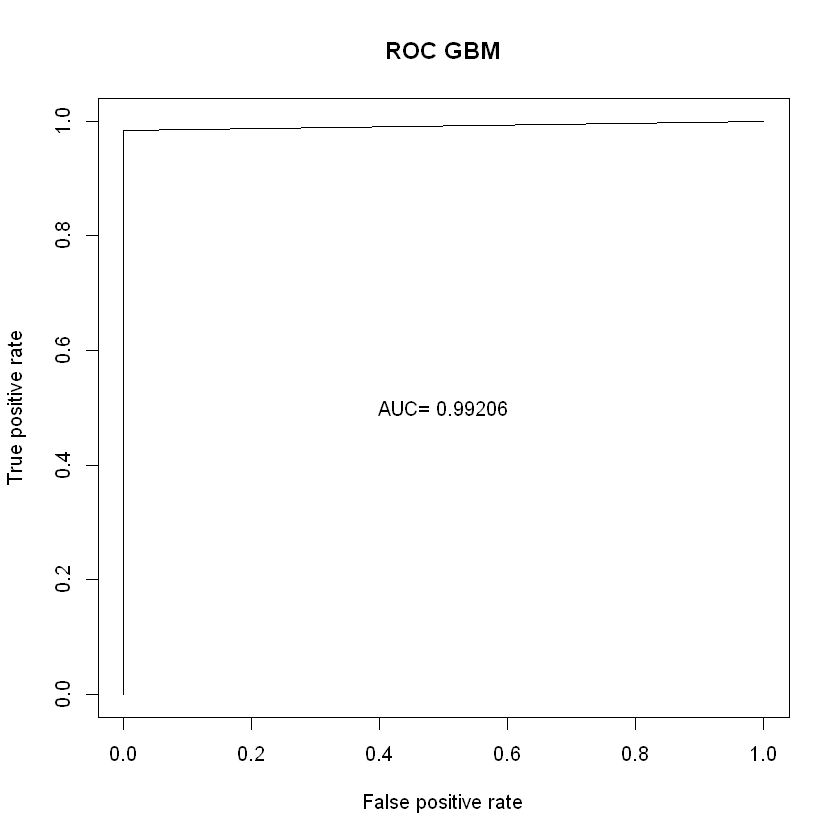

In [319]:
gbm<-mushroom_gbm(500)

## xgbm

[03:30:51] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1]	train-mlogloss:0.152916 
[2]	train-mlogloss:0.084274 


Setting levels: control = 0, case = 1
Setting direction: controls < cases


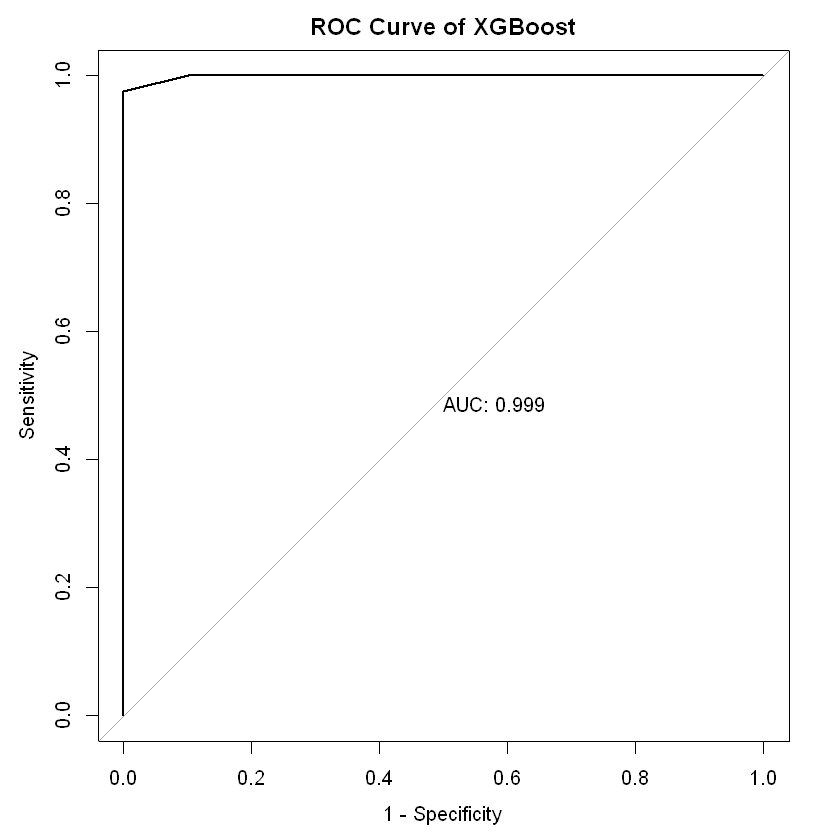

In [320]:
xgb<-mushroom_xgbm()

## Stacking

Setting levels: control = 0, case = 1
Setting direction: controls < cases


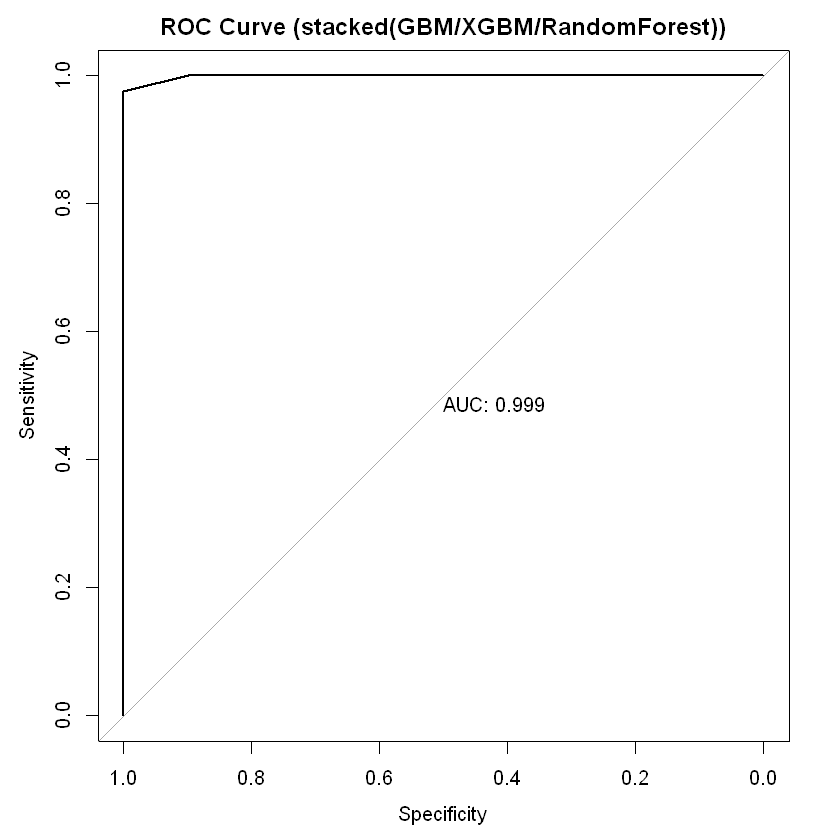

In [321]:
stackeddf<-data.frame(actual=tst$poisonous,
                      gbmpred=gbm$gbm_predicted,
                      xgbpred=xgb$xgb_pred_class,
                      randompred=randonForestpred$pred_class)
stacked_mean<-unlist(apply(stackeddf[,2:4],1,mean))
stacked_label<-ifelse(stacked_mean<0.5,0,1)
stackeddf<-cbind(stackeddf,stacked=stacked_label)
stbl<-table(stackeddf$actual,stacked_label)
scfm<-caret::confusionMatrix(stbl)
stk_acc<-sum(diag(stbl))/sum(stbl)
stk_pred_prob<-(xgb$xgb_pred[seq(0,length(xgb$xgb_pred),by=2)]+randonForestpred$rf100_pred+gbm$gbm_predict)/3
stk_roc<-roc(tst$poisonous~xgb$xgb_pred[seq(0,length(xgb$xgb_pred),by=2)],
             plot=TRUE,print.auc=TRUE,main='ROC Curve (stacked(GBM/XGBM/RandomForest))')

In [322]:
stk_auc<-auc(stk_roc)
accuracy<-function(x)sum(diag(x))/sum(x)
gbm_acc<-accuracy(gbm$gbm_tbl)
xgb_acc<-accuracy(xgb$xgb_tbl)

rf_acc<-accuracy(randonForestpred$rf100_mtab)
perfdf<-data.frame(algorithm=c("gbm","xgb","randomForest","STK"),acc=c(gbm_acc,xgb_acc,rf_acc,stk_acc),auc=c(gbm$gbm_auc,xgb$xgb_auc,
                                                                                              randonForestpred$rf_auc,stk_auc))
perfdf

algorithm,acc,auc
gbm,0.9927273,0.9920635
xgb,0.9890909,0.9988015
randomForest,0.9963636,1.0000000
STK,0.9927273,0.9988015


As we can see, stacking can increase both acc and auc (kind of same to randomForest), it has the highest or second highest average of acc and auc.

## Table of stat

I run ratioOfTrain from 0.1 to 1, and will show the result images below

### LOOCV/CrossValidation/Bagging

The following few lines of code will show ratio of training from 0.1 to 0.9 for all three algorithm in crossValidation/LOOCV/bagging.
However, even though I add parellel, the run time is long. 

In [335]:
algori<-list("svm","glm","naiveBayes")
for (i in 1:9){    
    mushroom <-dataPreprocess("./mushroom_afterRandomForest.csv",i*0.1)
    trainingSet<-mushroom$trainingSet
    tst<-mushroom$tst
    
    for (a in algori){
        cat("The ratio of training is", i)
        crossValidation(a)
        LOOCV(a)
        bagging(a)
        cat("#####################################################################\n")
    } 
}

The ratio of training is 1This is CrossValidation using svm 

For training data
            Accuracy                Kappa        AccuracyLower 
           1.0000000            1.0000000            0.6305834 
       AccuracyUpper         AccuracyNull          Sensitivity 
           1.0000000            0.5000000            1.0000000 
         Specificity       Pos Pred Value       Neg Pred Value 
           1.0000000            1.0000000            1.0000000 
           Precision               Recall                   F1 
           1.0000000            1.0000000            1.0000000 
          Prevalence       Detection Rate Detection Prevalence 
           0.5000000            0.5000000            0.5000000 
   Balanced Accuracy 
           1.0000000 

For test data
            Accuracy                Kappa        AccuracyLower 
           0.9368065            0.8735396            0.9168044 
       AccuracyUpper         AccuracyNull          Sensitivity 
           0.9532225         

According the table above, I got that for accuracy, SVM(highest)>naiveBayes>glm. for runtime SVM(slowest)>naiveBayes>glm(fastest)

### Bagging/gbm/xgbm/Stacking/randomForest

In case if run time is too long, so I use screen shot for this

ratioOfTrain = 0.1 

<img src="0.1.png"><img src="0.1bag.png">

ratioOfTrain = 0.2

<img src="0.2.png"><img src="0.2bag.png">

ratioOfTrain = 0.3

<img src="0.3.png"><img src="0.3bag.png">

ratioOfTrain = 0.4

<img src="0.4.png"><img src="0.4bag.png">

ratioOfTrain = 0.5

<img src="0.5.png"><img src="0.5bag.png">

ratioOfTrain = 0.6

<img src="0.6.png"><img src="0.6bag.png">

ratioOfTrain = 0.7

<img src="0.7.png"><img src="0.7bag.png">

ratioOfTrain = 0.8

<img src="0.8.png"><img src="0.8bag.png">

ratioOfTrain = 0.9

<img src="0.9.png"><img src="0.9bag.png">

ratioOfTrain = 1

<img src="1.png"><img src="1bag.png">

## Conclusion

According to the table, we found that randomForest has best performance on acc and auc, stacking is the second best.
gbm is on the third place and xgbm is under gbm. For my dataset, bagging using glm has relativly low performance, however, if I use svm for bagging, the result will be better.

For this HomeWork, I learned a lot about how to write reusable code and made them parellel, and that also took most of my time. However, that's really practical and I'm really enjoy that process!